<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N007 中心軸の推定

In [29]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

輪郭線の画素数は、左 268  右258


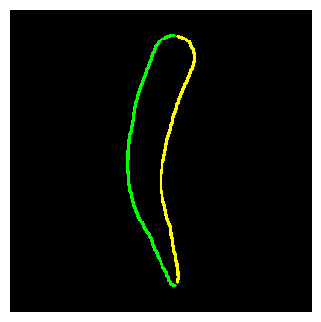

In [2]:
# 画像の左右の輪郭線を抽出　（N005参照）
img = imgs[2]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

# 仮中心軸の抽出
左右の輪郭線をベジエ曲線で近似し、両曲線の平均を求めることで仮の中心軸の近似曲線を得る

In [30]:
def getAverageBezline(img,N=6,n_samples=32,Amode=0,maxTry = 0):
    # img 画像
    # N ベジエ近似の次数
    # n_samples 左右輪郭線から取るサンプル点の数
    # Amode 近似方法 N006参照
    # maxTry Amode=1のときの、最大繰り返し回数
    
    # 左右の輪郭を抽出
    conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
    # 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
    #左右の輪郭点をベジエ近似する
    cntL  = rd.getSamples(conLeft,N=n_samples,mode='Equidistant')
    cntR = rd.getSamples(conRight,N=n_samples,mode='Equidistant')
    
    # ベジエ曲線のインスタンスを生成
    bezL = rd.BezierCurve(N=N,samples=cntL)
    bezR = rd.BezierCurve(N=N,samples=cntR)
    
    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    if Amode == 0:
        cpl,fL = bezL.fit0()
        cpr,fR = bezR.fit0()
    else:
        cpl,fL = bezL.fit1(maxTry)
        cpr,fR = bezR.fit1(maxTry)
        
    fC = (fL+fR)/2
    cpc = [x for x in (np.array(cpl)+np.array(cpr))/2]
    return cpl,cpr,cpc, fL,fR,fC,cntL,cntR



.....
.....


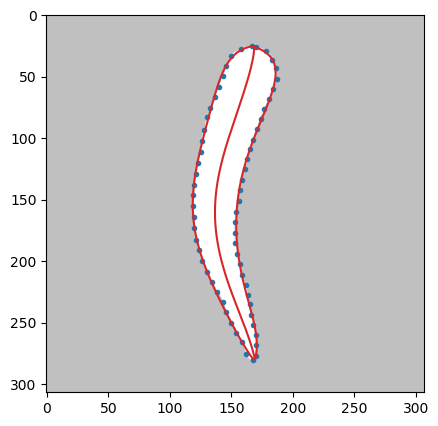

In [31]:
img = imgs[2]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=6,n_samples=32,Amode=1,maxTry=5)
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,figsize=(5,5),dpi=100)



.....
.....


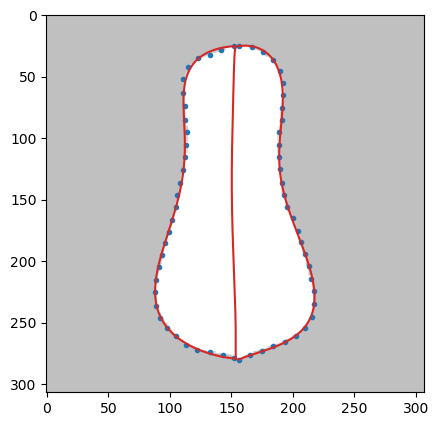

In [32]:
img = imgs[0]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=6,n_samples=32,Amode=1,maxTry=5)
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,figsize=(5,5),dpi=100)

　これらの結果を見ると中心軸の近似として妥当に見えるが、描画区間を延長してみると、端点部分で折り返すような関数となっていることがわかる。

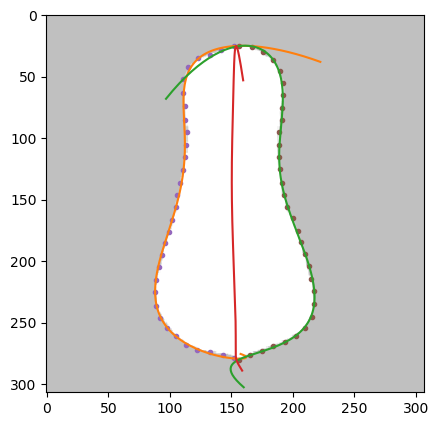

In [33]:
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,ct=list("123456789"),figsize=(5,5),dpi=100)

　そもそも中心線は輪郭ほど複雑ではないので、輪郭に用いるベジエ曲線の次数は必要な次数より過多であり、目的にもよるが、例えば曲がりの評価や、長さの測定には、3次あるいはせいぜい４次近似で充分ではないかと思われる。
 
 　試しに高速あてはめの3次と4次の近似を用いて中心線を出してみよう。

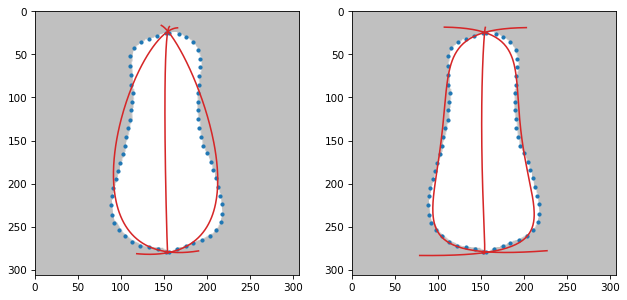

In [34]:
img = imgs[0]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

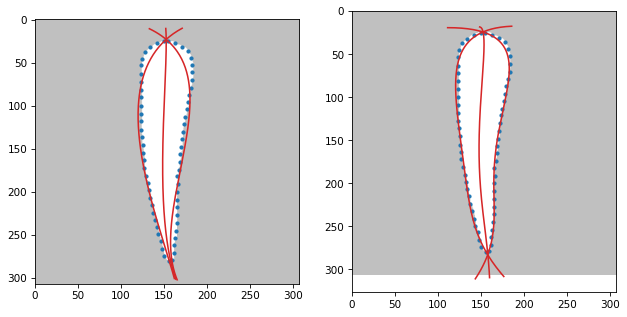

In [35]:
img = imgs[3]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

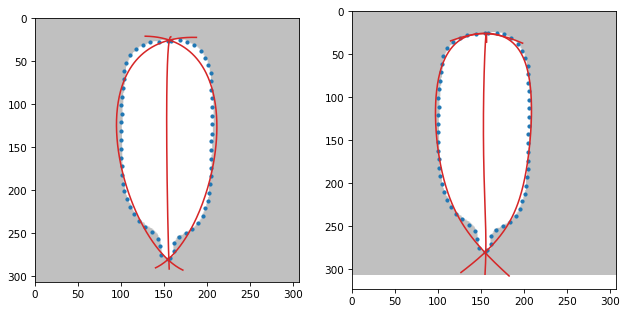

In [36]:
img = imgs[5]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

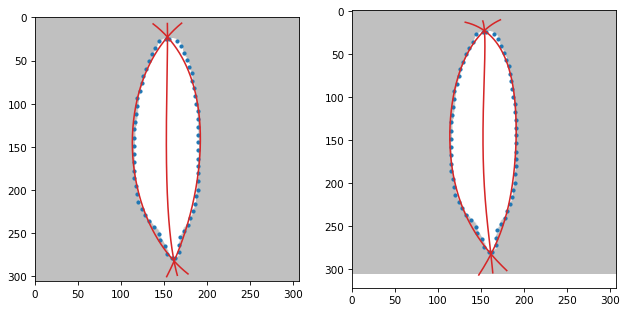

In [37]:
img = imgs[7]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

ここまでは３次でも４次でも、中心軸の近似としては良好な個体の例である。

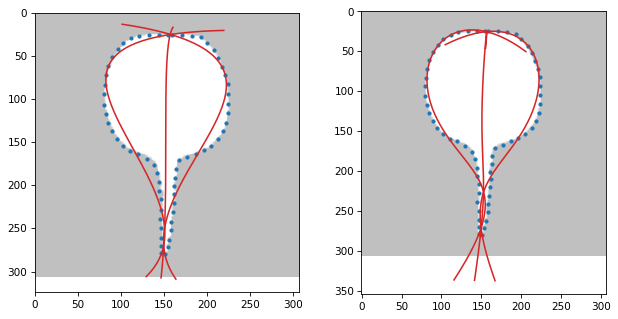

In [38]:
img = imgs[4]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

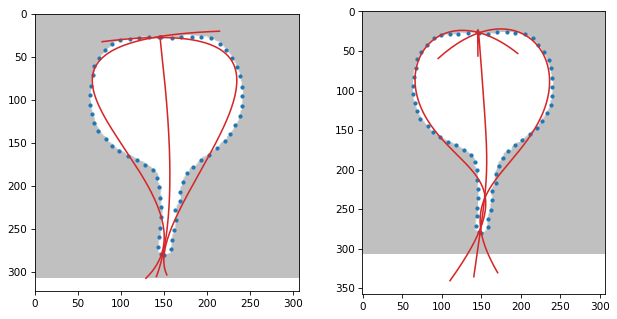

In [39]:
img = imgs[1]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

### ちょっと重要な考察
この２つの例は中心軸の近似としては十分満足できるのだが、このような肩の部分が丸みを帯びた個体の場合、上部の輪郭が少しでも内に回り込んでいると、合成で求めた中心軸のパラメトリック曲線はパラメータ０付近で急激にUターンするような形状になる。

（可能だとして）中心軸を直接近似するとすれば、そのような曲線をあてはめようとは思わないし、中心軸の点列がもし存在して曲線あてはめを行ったとしたら、やはりそのような曲線ではなく、上下に突き抜けるような曲線があてはめられるであろう。
 
 これは、ベジエ曲線のあてはめにおいて、必要以上に高い次数の曲線を用いると、同程度の誤差のあてはめは何通りも可能になってしまうということを示唆する（これは重要である）。
 
 また、そもそも「中心軸」はわれわれのイメージ、幻想でしかない。せいぜいが、対称性を見出せる個々の部分の対称軸の位置を通っていてほしい、というに過ぎず、正解がないので悩ましい。

- 軸対称の図形においてはその中心軸と一致してほしい。
- 部分的に軸対称である部分の中心を通ってほしい。
- 線対称図形の中心軸を変形してできるような図形、すなわちもとの中心軸に垂直な断面が変形前の断面に一致するような変形が加えられた図形であれば、その中心軸と一致してほしい。

　例えば、針金にウレタンゴムを巻いて作った棒を変形させてできるオブジェクトのシルエットから中心の針金の変形具合を求める、みたいな問題に取り組もうとしている。
 
 ベジエ曲線のあてはめに一意性がなければ、形状記述として意味がないかというと、そうは思わない。
 
 関数式としての記述を得ることによって、例えば曲線に沿った長さや幅を測定できたり、曲がりを補正した形状を作り出したり、といったことが可能になる。

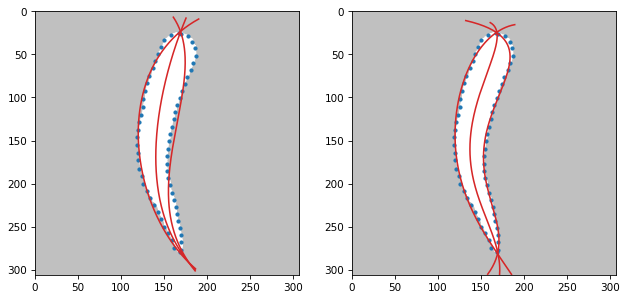

In [40]:
img = imgs[2]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

ほとんどの個体の中心軸の形状は３次近似で充分捉えられるのだが、３次と４次とでどちらが正確に形状をトレースできているかと問われると、４次に軍配を上げざるをえない。長さの計測という観点ならば、両者にそれほど差はなさそうな気はする。

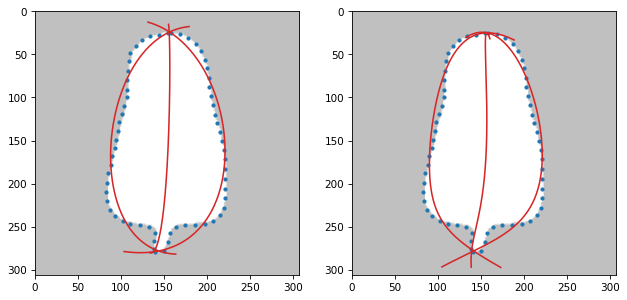

In [41]:
img = imgs[6]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

この図形の場合、尻尾が曲がっていたために、左右の輪郭の下端の位置にずれが生じているために、平均で求めた中心軸に歪が生じており、４次の方が影響が大きい。

この歪は形状を正確にトレースしているほど顕著になる。

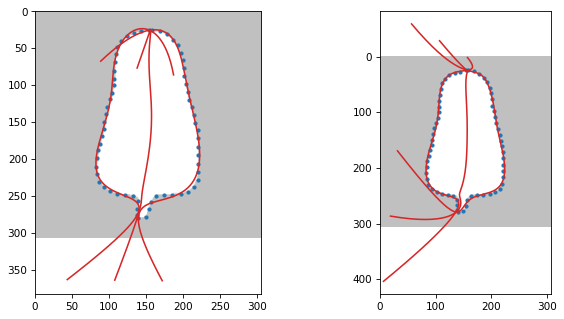

In [42]:
img = imgs[6]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=6,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75)
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=8,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None)

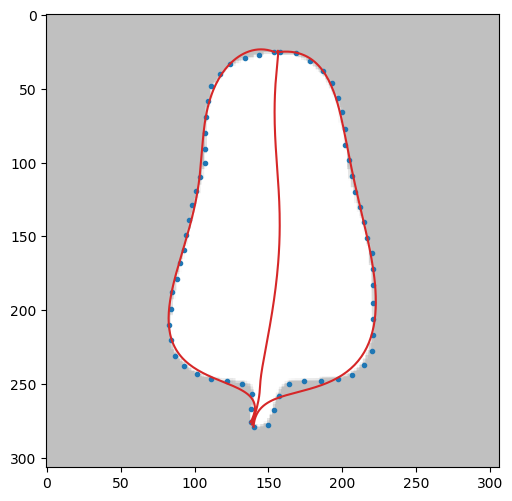

In [43]:
img = imgs[6]
cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=6,n_samples=32,Amode=0)
rd.drawBez(img,stt=-0,end=1.,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR)

# 中心軸の再近似
仮の中心軸は３次だと不十分、４次だと端点部分（特に上端）の傾きが不自然なので、関数式をもとにして標本点を生成した上で再近似してみる。
